# Tema 1 - A taste for music
## Găsirea genului pentru piese

### Autori: 
* George Muraru
* Alexandru Sorici

## 1. Scopul temei



Tema are ca scop folosirea metodelor de clasificare studiate în cadrul cursului/laboratorului pentru a **determina genul muzical** al unor sample-uri audio dintr-un set de date.

Se dorește înțelegerea procedurii tipice de **prelucrare a unui set de date**, de **explorare a atributelor**, precum și efectuarea unei **analize comparative** a mai multor algoritmi de clasificare, evidențiând diferențele între ei prin metrici precum *acuratețe, precizie, regăsire (eng. recall)*. 

## 2. Set de date

Primul pas în orice problema de data science este încărcarea și "înțelegerea" datelor.

Setul de date utilizat poartă denumirea de Free Music Archive [[1]](#fma). 

Dataset-ul utilizat este "usor" modificat - va conține doar 4 genuri muzicale: *Rock*, *Hip-Hop*, *Folk* și *Electronic*.

Setul de date este deja echilibrat (eng. balanced) -- sunt câte 500 de piese din fiecare gen în setul de train și câte 100 în cel de testare.

Dacă setați parametrul [DOWNLOAD_SAMPLE_DATASET](#scrollTo=te02bqsfMhls) se va descărca și un audio sample pentru fiecare track_id atunci când se rulează celula specifică pentru secțiunea [Descărcare](#scrollTo=RxCYjmzTM82o).

Puteți asculta sample-ul din piesă [aici](#scrollTo=te02bqsfMhls).

Se va folosi drept **clasă** (eticheta care trebuie prezisa) *genul muzical cel mai general* (numele coloanei în engleza este *top_genre*) pentru fiecare piesă.


Setul de date conține pentru fiecare sample mai multe atribute (eng. features), de tip numeric, care pot fi folosite pentru clasificare. Acestea pot fi găsite în fișierele *features.csv* sau *echonest.csv*.


Pentru mai multe informații privind setul de date, se poate consulta [acest repository](https://github.com/mdeff/fma).

Dataset-ul utilizat este o copie ușor modificată a celor [3 dataset-uri](https://github.com/mdeff/fma#Data): *fma_small.zip*, *fma_medium.zip*, *fma_large.zip*.

## 3. Workspace Setup

### Parametrii

In [1]:
# Music samples -- has ~ 2GB
DOWNLOAD_SAMPLE_DATASET = True  #@param {type: "boolean"}

### Dependențe

In [2]:
!pip install pandas # needed for loading the dataset
!pip install xgboost

if DOWNLOAD_SAMPLE_DATASET:
    !pip install ffmpeg # Needed by librosa for mp3
    #!pip install librosa
    !pip install tqdm # Progress bar for dowloading large file

  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp37-none-any.whl size=6083 sha256=9820e09151f67d2553e4da025cb5ca1528dff668f9ec459ac826887b1e366b2f
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg


### Import biblioteci

In [3]:
if DOWNLOAD_SAMPLE_DATASET:
    from tqdm import tqdm
    #import librosa


from zipfile import ZipFile
import IPython.display as ipd

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, mutual_info_classif, SelectPercentile
from sklearn.pipeline import Pipeline

from sklearn.metrics.cluster import silhouette_score #for kmeans
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report # for supervised methods

### Funcții ajutătoare

In [4]:
def _reporthook(t):
    """ ``reporthook`` to use with ``urllib.request`` that prints the process of the download.

    Uses ``tqdm`` for progress bar.

    **Reference:**
    https://github.com/tqdm/tqdm

    Args:
        t (tqdm.tqdm) Progress bar.
    """
    last_b = [0]

    def inner(b=1, bsize=1, tsize=None):
        """
        Args:
            b (int, optional): Number of blocks just transferred [default: 1].
            bsize (int, optional): Size of each block (in tqdm units) [default: 1].
            tsize (int, optional): Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return inner

def getHomeworkArchives():
    """ Checks if the homework dataset is present in the local directory, if not,
    downloads it.
    """
    from os import path

    dataset_info = {
        "fma_song_info.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_info.zip",
        "fma_song_samples.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_samples.zip" # Need to upload this
    }

    for dataset_file, dataset_url in dataset_info.items():
        if not path.isfile(dataset_file):
            import urllib
            with tqdm(unit='B', unit_scale=True, miniters=1, desc=dataset_file) as t:
                urllib.request.urlretrieve(dataset_url, filename=dataset_file, reporthook=_reporthook(t))

            assert(path.isfile(dataset_file))

            with ZipFile(dataset_file, 'r') as zip_ref:
                zip_ref.extractall()
        else:
            print(f"{dataset_file} already in the local directory")


# ALL THE FUCTIONS FROM THIS POINT FORWARD ARE NEEDED ONLY IF
# DOWNLOAD_SAMPLE_DATASET IS TRUE
def load_tracks():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/tracks.csv"), index_col=0, header=[0,1])


def load_features():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open('song_info/features.csv'), index_col=0, header=[0,1,2])


def load_echonest():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/echonest.csv"), index_col=0, header=[0,1,2])


def get_song_path(track_id: int):
    ''' Given a track id return the path to the sample

    Args:
        track_id (int): the id for a song found the dataset

    Returns:
        The path to the sample relative to the current directory
    '''

    return f'song_samples/{track_id:06}.mp3'

### Descărcare

In [5]:
getHomeworkArchives()

fma_song_info.zip: 12.3MB [00:01, 7.10MB/s]                           
fma_song_samples.zip: 2.14GB [01:27, 24.6MB/s]                            


### Încărcare date

In [6]:
# Load Echonest features for our dataset
echonest = load_echonest()
tracks = load_tracks()
features = load_features()

# True/False masks for selecting training/test
TRAIN_MASK = tracks['set', 'split'] == 'training'
VALIDATION_MASK = tracks['set', 'split'] == 'validation'
TEST_MASK = tracks['set', 'split'] == 'test'

# concat audio_features + temporal_features + social_features
X_train = np.asarray(echonest.loc[TRAIN_MASK, ('echonest', 'audio_features')])
X_validation = np.asarray(echonest.loc[VALIDATION_MASK, ('echonest', 'audio_features')])
X_test = np.asarray(echonest.loc[TEST_MASK, ('echonest', 'audio_features')])
X_validation_test = np.concatenate([X_validation, X_test], axis=0)
X_all = np.concatenate([X_train, X_validation, X_test], axis=0)

# select the labels and convert to idx
label_to_idx_mapping = {"Rock":0, "Hip-Hop":1, "Folk":2, "Electronic":3}

Y_train = tracks.loc[TRAIN_MASK, ('track', 'genre_top')]
Y_validation = tracks.loc[VALIDATION_MASK, ('track', 'genre_top')]
Y_test = tracks.loc[TEST_MASK, ('track', 'genre_top')]

Y_train = np.asarray([label_to_idx_mapping[lbl] for lbl in Y_train])
Y_validation = np.asarray([label_to_idx_mapping[lbl] for lbl in Y_validation])
Y_test = np.asarray([label_to_idx_mapping[lbl] for lbl in Y_test])
Y_validation_test = np.concatenate([Y_validation, Y_test], axis=0)
Y_all = np.concatenate([Y_train, Y_validation, Y_test], axis=0)

print("X_train shape: {}, Y_train_shape: {}".format(X_train.shape, Y_train.shape))
print("X_validation shape: {}, Y_validation shape: {}".format(X_validation.shape, Y_validation.shape))
print("X_test shape: {}, Y_test shape: {}".format(X_test.shape, Y_test.shape))
print("X_validation_test shape: {}, Y_validation_test shape: {}".format(X_validation_test.shape, Y_validation_test.shape))
print("X_all shape: {}, Y_all shape: {}".format(X_all.shape, Y_all.shape))

X_train shape: (2000, 8), Y_train_shape: (2000,)
X_validation shape: (225, 8), Y_validation shape: (225,)
X_test shape: (175, 8), Y_test shape: (175,)
X_validation_test shape: (400, 8), Y_validation_test shape: (400,)
X_all shape: (2400, 8), Y_all shape: (2400,)


## 4. Problemă de rezolvat



Împărțim problema de rezolvat a acestei teme în două subpuncte principale:
  * Implementarea unui clasificator al genului muzical (eng. genre) pentru un anumit sample de piesă prin intermediul a patru algoritmi (KMeans, Decision Trees/Random Forest, XGBoost, SVM, Naive Bayes). Construirea unei variante de baza (eng. baseline) a clasificatorului pentru fiecare algoritm propus.
  * Explorarea metodelor prin care pot fi îmbunătățite rezultatele fiecarui algoritm în parte (e.g. varierea atributelor, prelucrarea suplimentară a atributelor, modificarea hiperparametrilor algoritmului), evaluarea comparativă intra- (i.e. față de baseline pentru același tip de algoritm) și inter-algoritm.

### 4.1. Implementare si rulare clasificatori [6pct]

Pentru acest task se vor rula mai mulți algoritmi pe setul de date și vor fi notate rezultatele obținute.

Veți crea câte un clasificator folosind fiecare din cei patru algoritmi din următoarea listă:
  * KMeans [1 pct]
  * Arbori de decizie, păduri aleatoare [1 pct]
  * XGBoost [1 pct]
  * SVM [1 pct]
  * Naive Bayes [1 pct]

**Observație 1:** Pentru KMeans, fiind **nesupervizat**, vom presupune că *nu* se știe că numărul de clustere este 4.

**Observație 2:** Algoritmii listați **nu** trebuie implementati de mana (nu obligatoriu). Este permisă utilizarea versiunilor din biblioteci cunoscute (a se vedea exemplele sugerate mai jos).


#### **Utilizarea setului de date**
În general, majoritatea seturilor de date sunt împărțite în:
* setul de antrenare (eng. training dataset) - se rulează algoritmul de învățare pe acest set (eng. fit the model)
* setul de validare (eng. validation dataset sau dev set) - se utilizează pentru modificarea hiperparametrilor algoritmului (eng. tunning the hyperparameters)
* setul de testare (eng. testing dataset sau holdout dataset) - se rulează pentru testarea finală a algoritmului.

În scheletul temei, testul de validare și de testare sunt concatenate.

#### **Implementare algoritmi**
Dezvoltați clasificatorii *baseline* pe baza fiecărui algoritm din cei listați mai sus. 
Utilizați implementările default din bibliotecile alese pentru a obține baseline-ul.
Folosiți drept features *audio_features* din tabela de *echonest* (sunt deja selectate în schelet).

Folosiți set-ul *train* pentru antrenare și *test* pentru testare.

#### **Evaluare** [1 pct]
Găsiți [aici](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) o listă cu metrici folosite, in general, pentru evaluarea algoritmilor de machine learning.

Pentru fiecare algoritm în parte, raportați **cel puțin** metricile de *accuracy*, *precision*, *recall*, *f-score* și *matricea de confuzie (eng. confusion matrix)*.

**Observații KMeans**
1. Având în vedere că KMeans nu este un algoritm supervizat, putem să combinăm cele 2 seturi de date (train + testare) pentru a face clusterizarea.
2. Faceți rescale *feature-urilor* astfel încât acestea să fie centrate în 0 cu o deviație standard de 1 - [standardizarea datelor](#scrollTo=-tkdMwB5S-as)
3. Rulați KMeans pe setul de antrenare utilizând un număr diferit de clustere (eg. 2, 3, 4, 5, 6).
4. Verificați utlizând metoda [silhouette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) care este numărul optim de clustere (puteți încerca și cu [elbow](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml) însă va trebui să creșteți lungmea intervalului de clustere).
5. Alegeți numărul optim de clustere și calculați **doar** *randIndex*.
6. [Opțional] Puteți analiza coordonatele centroizilor pentru a observa cum diferă genurile muzicale în funcție de *audio_features*. 
6. [Opțional] Puteți testa să vedeți că piesele din același cluster seamănă utilizând codul de [aici](#scrollTo=fS6s1c-gPyMN).

**Observații DecisionTree/RandomForest**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) din biblioteca scikit-learn. 

**Observații XGBoost**

Implementarea sugerată este cea din biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

**Observații SVM**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/svm.html) din biblioteca scikit-learn.

**Observații Naive Bayes**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/naive_bayes.html) din bibilioteca scikit-learn.

#### Metrics Helpers

In [7]:
def rand_index(y_pred, y_truth):
    assert len(y_pred) == len(y_truth), "y_pred has len {}, while y_truth has len {}".format(len(y_pred), len(y_truth))
    n = len(y_pred)
    
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for i in range(n):
        for j in range(i + 1, n):
            if y_pred[i] == y_pred[j] and y_truth[i] == y_truth[j]:
                tp += 1
            elif y_pred[i] == y_pred[j] and y_truth[i] != y_truth[j]:
                fp += 1
            elif y_pred[i] != y_pred[j] and y_truth[i] != y_truth[j]:
                tn += 1
            elif y_pred[i] != y_pred[j] and y_truth[i] == y_truth[j]:
                fn += 1
    
    assert tp + fp + tn + fn != 0, "The sum tp + fp + tn + fn cannot be equal to 0"
    return (tp + tn) / (tp + fp + tn + fn)

# plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, colour):
    fig_ac = plt.figure(figsize=(8, 8))
    resulted_confusion_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(resulted_confusion_matrix, fmt="d", annot=True, cbar=False, cmap=colour, linewidths=.5, square=True)
    plt.close()
    display(fig_ac)
    print(classification_report(y_true, y_pred))
    
SUPERVISED_SCORES = {"accuracy": accuracy_score, "recall": recall_score, "precision": precision_score, "f1": f1_score}

def apply_metric_func(y_true, y_pred, func_list):        
    scores = []
    d = {}
    for func_name in func_list:
        func = func_list[func_name]
        
        if func != accuracy_score:
            score_aux = func(y_true, y_pred, average='weighted')
        else:
            score_aux = func(y_true, y_pred)
        
        d[func_name] = score_aux
    
    return d

KMEANS_KEY = "kmeans"
DECISION_TREE_KEY = "decisionTree"
RANDOM_FOREST_KEY = "randomForest"
XGBOOST_key = "xgboost"
SVM_KEY = "svm"
NAIVE_BAYES_KEY = "naiveBayes"

SCORES_PER_METHOD = {KMEANS_KEY:{}, DECISION_TREE_KEY:{}, RANDOM_FOREST_KEY:{}, XGBOOST_key:{}, SVM_KEY:{}, NAIVE_BAYES_KEY:{}}

## KMeans

In [8]:
def train_simple_kmeans(x_all, y_all, n_clusters_list):    
    # normalize on train (and transform with computed mean and std on test)
    x_all_normalized = StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(x_all)
    
    d = {"n_clusters":[], "silhouetteScore": [], "randIndex":[]}
    # run a loop to fit for each n_clusters value from n_clusters_list
    for n_clusters in n_clusters_list:
        # fit the model
        y_predicted = KMeans(n_clusters=n_clusters).fit_predict(x_all_normalized)
        
        # calculate different metrics
        silhouetteScore = silhouette_score(x_all_normalized, y_predicted)
        randIndex = rand_index(y_predicted, y_all)
        d["n_clusters"].append(n_clusters)
        d["silhouetteScore"].append(silhouetteScore)
        d["randIndex"].append(randIndex)
    
    print("##### Kmeans simple #####")
    df = pd.DataFrame(d).sort_values(by=["silhouetteScore"], ascending=False)
    print(df)
    
    return df["silhouetteScore"].iloc[0]

res = train_simple_kmeans(x_all=X_all, y_all=Y_all, n_clusters_list=[2,3,4,5,6,7])
SCORES_PER_METHOD[KMEANS_KEY]["simple"] = {"randIndex": res} 

##### Kmeans simple #####
   n_clusters  silhouetteScore  randIndex
2           4         0.187649   0.675601
4           6         0.180239   0.713267
3           5         0.179403   0.704803
0           2         0.172705   0.576723
1           3         0.172324   0.671197
5           7         0.168116   0.723842


## Decision Tree and Random Forests

##### DecisionTree #####


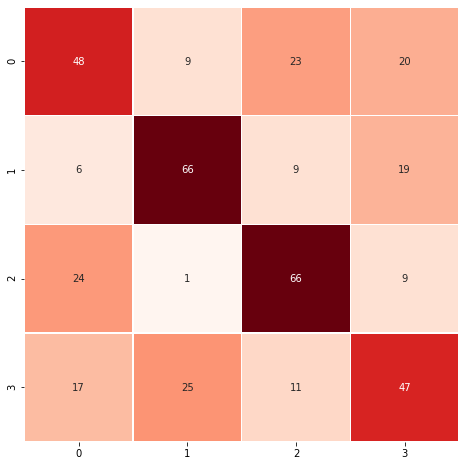

              precision    recall  f1-score   support

           0       0.51      0.48      0.49       100
           1       0.65      0.66      0.66       100
           2       0.61      0.66      0.63       100
           3       0.49      0.47      0.48       100

    accuracy                           0.57       400
   macro avg       0.56      0.57      0.57       400
weighted avg       0.56      0.57      0.57       400

{'accuracy': 0.5675, 'recall': 0.5675, 'precision': 0.5647424834226542, 'f1': 0.5656635849094608} 
############################################

##### RandomForest #####


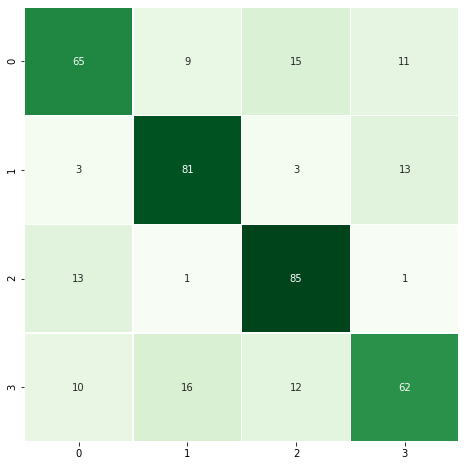

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       100
           1       0.76      0.81      0.78       100
           2       0.74      0.85      0.79       100
           3       0.71      0.62      0.66       100

    accuracy                           0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.73      0.73      0.73       400

{'accuracy': 0.7325, 'recall': 0.7325, 'precision': 0.7307672932559087, 'f1': 0.7292590616500405} 
############################################



In [9]:
def train_simple_decisionTree(x_train, y_train, x_test, y_test):
    y_test_predicted = DecisionTreeClassifier().fit(x_train, y_train).predict(x_test)
    print("##### DecisionTree #####")
    plot_confusion_matrix(y_test, y_test_predicted, colour="Reds")
    return apply_metric_func(y_true=y_test, y_pred=y_test_predicted, func_list=SUPERVISED_SCORES)

def train_simple_randomForest(x_train, y_train, x_test, y_test):
    y_test_predicted = RandomForestClassifier().fit(x_train, y_train).predict(x_test)
    print("##### RandomForest #####")
    plot_confusion_matrix(y_test, y_test_predicted, colour="Greens")
    return apply_metric_func(y_true=y_test, y_pred=y_test_predicted, func_list=SUPERVISED_SCORES)

decisionTree_res = train_simple_decisionTree(x_train=X_train, y_train=Y_train, x_test=X_validation_test, y_test=Y_validation_test)
print(decisionTree_res, "\n############################################\n")
SCORES_PER_METHOD[DECISION_TREE_KEY]["simple"] = decisionTree_res 

randomForest_res = train_simple_randomForest(x_train=X_train, y_train=Y_train, x_test=X_validation_test, y_test=Y_validation_test)
print(randomForest_res, "\n############################################\n")
SCORES_PER_METHOD[RANDOM_FOREST_KEY]["simple"] = randomForest_res

## XGBoost

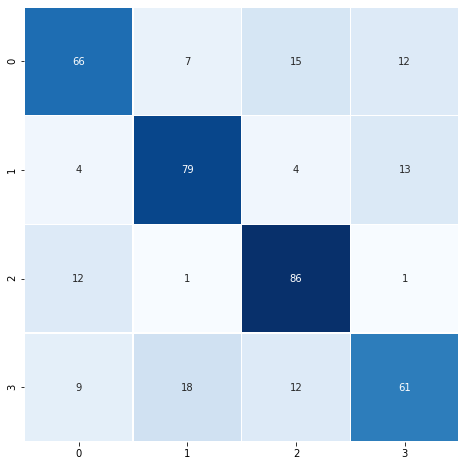

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       100
           1       0.75      0.79      0.77       100
           2       0.74      0.86      0.79       100
           3       0.70      0.61      0.65       100

    accuracy                           0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.73      0.73      0.73       400



In [10]:
def train_simple_xgboost(x_train, y_train, x_test, y_test):
    y_test_predicted = xgb.XGBClassifier().fit(x_train, y_train).predict(x_test)
    plot_confusion_matrix(y_test, y_test_predicted, colour="Blues")
    return apply_metric_func(y_true=y_test, y_pred=y_test_predicted, func_list=SUPERVISED_SCORES)    
    
xgboost_res = train_simple_xgboost(x_train=X_train, y_train=Y_train, x_test=X_validation_test, y_test=Y_validation_test)
SCORES_PER_METHOD[XGBOOST_key]["simple"] = xgboost_res

## SVM

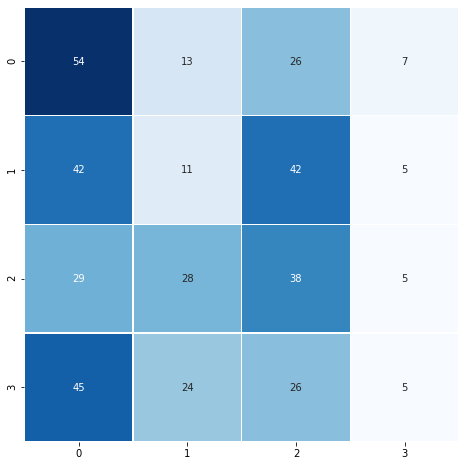

              precision    recall  f1-score   support

           0       0.32      0.54      0.40       100
           1       0.14      0.11      0.12       100
           2       0.29      0.38      0.33       100
           3       0.23      0.05      0.08       100

    accuracy                           0.27       400
   macro avg       0.24      0.27      0.23       400
weighted avg       0.24      0.27      0.23       400



In [11]:
def train_simple_svm(x_train, y_train, x_test, y_test):
    y_test_predicted = svm.SVC().fit(x_train, y_train).predict(x_test)
    plot_confusion_matrix(y_test, y_test_predicted, colour="Blues")
    return apply_metric_func(y_true=y_test, y_pred=y_test_predicted, func_list=SUPERVISED_SCORES)    
    
svm_res = train_simple_svm(x_train=X_train, y_train=Y_train, x_test=X_validation_test, y_test=Y_validation_test)
SCORES_PER_METHOD[SVM_KEY]["simple"] = svm_res

## Naive Bayes

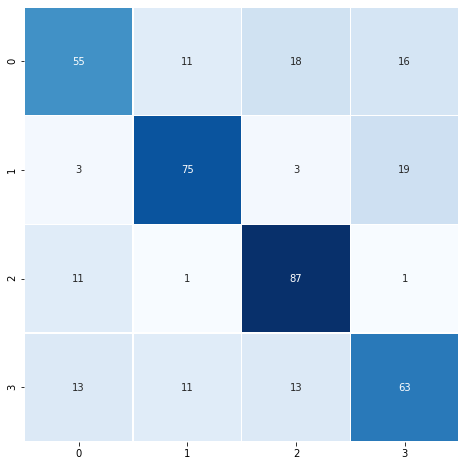

              precision    recall  f1-score   support

           0       0.67      0.55      0.60       100
           1       0.77      0.75      0.76       100
           2       0.72      0.87      0.79       100
           3       0.64      0.63      0.63       100

    accuracy                           0.70       400
   macro avg       0.70      0.70      0.70       400
weighted avg       0.70      0.70      0.70       400



In [12]:
def train_simple_naiveBayes(x_train, y_train, x_test, y_test):
    y_test_predicted = GaussianNB().fit(x_train, y_train).predict(x_test)
    plot_confusion_matrix(y_test, y_test_predicted, colour="Blues")
    return apply_metric_func(y_true=y_test, y_pred=y_test_predicted, func_list=SUPERVISED_SCORES)  

naiveBayes_res = train_simple_naiveBayes(x_train=X_train, y_train=Y_train, x_test=X_validation_test, y_test=Y_validation_test)
SCORES_PER_METHOD[NAIVE_BAYES_KEY]["simple"] = naiveBayes_res

### 4.2. Metode de îmbunătățire și evaluare comparativă [4pct]

Pentru fiecare algoritm, explorați metode prin care să îmbunătățiți performanțele de la pasul precedent (cel de realizarea a baseline-ului).

**Îmbunătățire algoritmi** [2 pct]

Aveți în vedere următoarea listă de idei (și nu numai):
* adăugarea de mai multe feature-uri (momentan la baseline s-au folosit doar *audio_features*)
* [preprocesarea datelor](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) (eng. data preprocessing)
* [selectarea atributelor](https://scikit-learn.org/stable/modules/feature_selection.html) (eng. feature selection)
* modificarea hiperparametrilor fiecărui algoritm (e.g. tipul de kernel la SVM, coeficienți de regularizare, numărul de arbori în RandomForest, adâncimea arborilor în RandomForest)
    * **Atenție!**, exemplu de **AȘA NU**: rularea cu un număr maxim de 10 iterații la baseline și 100 de iterații la modelul mai bun.

În *fma_song_info.zip* există și un fișier *features.csv* -- detalii despre acesta se găsesc în repository-ul menționat în secțiunea [Set de date](#scrollTo=67UlrcAdqj3N).

**Evaluare îmbunătățiri** [2 pct]

* Evaluați variantele îmbunătățite ale algoritmilor, folosind 5-fold [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/). Folosiți aceleași metrici ca în cazul baseline-ului.  **Atenție!** Pentru cross-validation trebuie să vă refaceti împartirea in train/test a setului de date.
* Realizați grafice în care să arătați analiza intra-algoritm a performanței îmbunătățirii (e.g. folosiți un bar chart pentru a compara accuracy-ul variantei baseline a RandomForest cu cea a variantei îmbunătățite).
* Realizați grafice în care să arătați analiza inter-algoritm a performanțelor. Faceți câte un grafic per metrică (e.g. accuracy, precision, recall) în care să încludeți valorile obținute de fiecare algoritm îmbunătățit în parte. 
* Redactați, pe seama graficelor, o analiză a acestora, evidențiind avantajele și dezavantajele fiecărui algoritm implementat.

In [13]:
## Add more features

In [14]:
def extract_features_from_echonest(echonest, subset):
    return np.concatenate([echonest.loc[subset, ('echonest', 'audio_features')], echonest.loc[subset, ('echonest', 'temporal_features')], echonest.loc[subset, ('echonest', 'social_features')]], axis=1)

def extract_features_from_features(features, subset):
    return np.asarray(features.loc[subset])

def combine_features(features, echonest, subset):
    return np.concatenate([extract_features_from_features(features, subset), extract_features_from_echonest(echonest, subset)], axis=1)
    

# concat audio_features + temporal_features + social_features
X_train = combine_features(features, echonest, TRAIN_MASK)
X_validation = combine_features(features, echonest, VALIDATION_MASK)
X_test = combine_features(features, echonest, TEST_MASK)
X_validation_test = np.concatenate([X_validation, X_test], axis=0)
X_all = np.concatenate([X_train, X_validation, X_test], axis=0)
     
# select the labels and convert to idx
label_to_idx_mapping = {"Rock":0, "Hip-Hop":1, "Folk":2, "Electronic":3}

Y_train = tracks.loc[TRAIN_MASK, ('track', 'genre_top')]
Y_validation = tracks.loc[VALIDATION_MASK, ('track', 'genre_top')]
Y_test = tracks.loc[TEST_MASK, ('track', 'genre_top')]

Y_train = np.asarray([label_to_idx_mapping[x] for x in Y_train])
Y_validation = np.asarray([label_to_idx_mapping[x] for x in Y_validation])
Y_test = np.asarray([label_to_idx_mapping[x] for x in Y_test])
Y_validation_test = np.concatenate([Y_validation, Y_test], axis=0)
Y_all = np.concatenate([Y_train, Y_validation, Y_test], axis=0)

print("X_train shape: {}, Y_train_shape: {}".format(X_train.shape, Y_train.shape))
print("X_validation shape: {}, Y_validation shape: {}".format(X_validation.shape, Y_validation.shape))
print("X_test shape: {}, Y_test shape: {}".format(X_test.shape, Y_test.shape))
print("X_validation_test shape: {}, Y_validation_test shape: {}".format(X_validation_test.shape, Y_validation_test.shape))
print("X_all shape: {}, Y_all shape: {}".format(X_all.shape, Y_all.shape))

X_train shape: (2000, 755), Y_train_shape: (2000,)
X_validation shape: (225, 755), Y_validation shape: (225,)
X_test shape: (175, 755), Y_test shape: (175,)
X_validation_test shape: (400, 755), Y_validation_test shape: (400,)
X_all shape: (2400, 755), Y_all shape: (2400,)


## Select K best Features (k=100)

In [15]:
selectKBest = SelectKBest(k=100)
selectKBest.fit(X_train, Y_train)

X_train = selectKBest.transform(X_train)
X_validation = selectKBest.transform(X_validation)
X_test = selectKBest.transform(X_test)
X_validation_test = selectKBest.transform(X_validation_test)
X_all = selectKBest.transform(X_all)

print("X_train shape: {}, Y_train_shape: {}".format(X_train.shape, Y_train.shape))
print("X_validation shape: {}, Y_validation shape: {}".format(X_validation.shape, Y_validation.shape))
print("X_test shape: {}, Y_test shape: {}".format(X_test.shape, Y_test.shape))
print("X_validation_test shape: {}, Y_validation_test shape: {}".format(X_validation_test.shape, Y_validation_test.shape))
print("X_all shape: {}, Y_all shape: {}".format(X_all.shape, Y_all.shape))

X_train shape: (2000, 100), Y_train_shape: (2000,)
X_validation shape: (225, 100), Y_validation shape: (225,)
X_test shape: (175, 100), Y_test shape: (175,)
X_validation_test shape: (400, 100), Y_validation_test shape: (400,)
X_all shape: (2400, 100), Y_all shape: (2400,)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [180 183 184 189] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


## Add polynomial features (degree=2)

In [16]:
'''
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_train = poly.fit_transform(X_train)
X_validation = poly.fit_transform(X_validation)
X_test = poly.fit_transform(X_test)
X_validation_test = poly.fit_transform(X_validation_test)
X_all = poly.fit_transform(X_all)

print("X_train shape: {}, Y_train_shape: {}".format(X_train.shape, Y_train.shape))
print("X_validation shape: {}, Y_validation shape: {}".format(X_validation.shape, Y_validation.shape))
print("X_test shape: {}, Y_test shape: {}".format(X_test.shape, Y_test.shape))
print("X_validation_test shape: {}, Y_validation_test shape: {}".format(X_validation_test.shape, Y_validation_test.shape))
print("X_all shape: {}, Y_all shape: {}".format(X_all.shape, Y_all.shape))
'''

'\nfrom sklearn.preprocessing import PolynomialFeatures\n\npoly = PolynomialFeatures(2)\n\nX_train = poly.fit_transform(X_train)\nX_validation = poly.fit_transform(X_validation)\nX_test = poly.fit_transform(X_test)\nX_validation_test = poly.fit_transform(X_validation_test)\nX_all = poly.fit_transform(X_all)\n\nprint("X_train shape: {}, Y_train_shape: {}".format(X_train.shape, Y_train.shape))\nprint("X_validation shape: {}, Y_validation shape: {}".format(X_validation.shape, Y_validation.shape))\nprint("X_test shape: {}, Y_test shape: {}".format(X_test.shape, Y_test.shape))\nprint("X_validation_test shape: {}, Y_validation_test shape: {}".format(X_validation_test.shape, Y_validation_test.shape))\nprint("X_all shape: {}, Y_all shape: {}".format(X_all.shape, Y_all.shape))\n'

## Normalize the data

In [17]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler = scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)
X_validation_test = scaler.transform(X_validation_test)
X_all = scaler.transform(X_all)

print("X_train shape: {}, Y_train_shape: {}".format(X_train.shape, Y_train.shape))
print("X_validation shape: {}, Y_validation shape: {}".format(X_validation.shape, Y_validation.shape))
print("X_test shape: {}, Y_test shape: {}".format(X_test.shape, Y_test.shape))
print("X_validation_test shape: {}, Y_validation_test shape: {}".format(X_validation_test.shape, Y_validation_test.shape))
print("X_all shape: {}, Y_all shape: {}".format(X_all.shape, Y_all.shape))

X_train shape: (2000, 100), Y_train_shape: (2000,)
X_validation shape: (225, 100), Y_validation shape: (225,)
X_test shape: (175, 100), Y_test shape: (175,)
X_validation_test shape: (400, 100), Y_validation_test shape: (400,)
X_all shape: (2400, 100), Y_all shape: (2400,)


## Kmeans optimized

In [18]:
def train_optimized_kmeans(x_all, y_all):
    parameters = {"n_clusters": [2, 3, 4, 5, 6],
                  "max_iter": [10000],
                  "init": ["k-means++", "random"],
                  "algorithm": ["auto", "full", "elkan"]
                  }

    grid_search = GridSearchCV(KMeans(),
                               parameters,
                               refit=True,
                               cv=5,
                               scoring='adjusted_rand_score').fit(x_all, y_all)
    best_model = grid_search.best_estimator_
    y_predicted_all = best_model.predict(x_all)
    randIndex = rand_index(y_pred=y_predicted_all, y_truth=y_all)
    print("BestModel: {}".format(best_model))
    print("RandIndex: {}".format(randIndex))
    return randIndex

kmeans_res = train_optimized_kmeans(x_all=X_all, y_all=Y_all)
SCORES_PER_METHOD[KMEANS_KEY]["optimized"] = {"randIndex": kmeans_res}

BestModel: KMeans(algorithm='full', copy_x=True, init='random', max_iter=10000,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
RandIndex: 0.7249378213144366


## Decision Tree and Random Forests optimized

##### DecisionTree Optimized #####
Best model DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


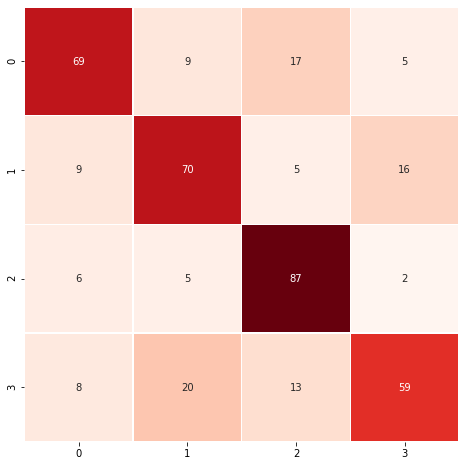

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       100
           1       0.67      0.70      0.69       100
           2       0.71      0.87      0.78       100
           3       0.72      0.59      0.65       100

    accuracy                           0.71       400
   macro avg       0.71      0.71      0.71       400
weighted avg       0.71      0.71      0.71       400

{'accuracy': 0.7125, 'recall': 0.7125, 'precision': 0.7139259680743087, 'f1': 0.7092899854848385} 
############################################

##### RandomForest Optimized #####
Best model RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                      

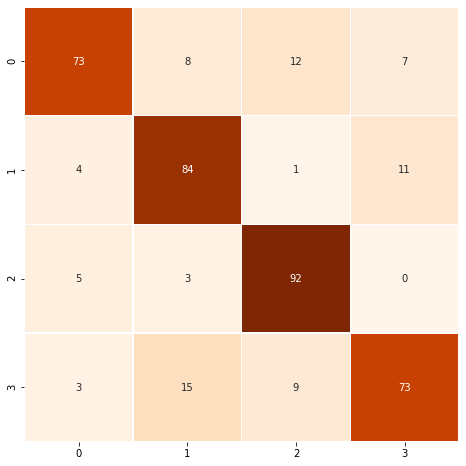

              precision    recall  f1-score   support

           0       0.86      0.73      0.79       100
           1       0.76      0.84      0.80       100
           2       0.81      0.92      0.86       100
           3       0.80      0.73      0.76       100

    accuracy                           0.81       400
   macro avg       0.81      0.80      0.80       400
weighted avg       0.81      0.81      0.80       400

{'accuracy': 0.805, 'recall': 0.805, 'precision': 0.807918809776395, 'f1': 0.8033500447651253} 
############################################



In [19]:
def train_optimized_decisionTree(x_train, y_train, x_test, y_test):
    params = {
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5],
    'criterion':['gini', 'entropy'],
    'min_samples_leaf': [1, 3]
    }

    gridsearch = GridSearchCV(DecisionTreeClassifier(), params, refit=True, cv=5, scoring='balanced_accuracy').fit(x_train, y_train)
    best_model = gridsearch.best_estimator_
    y_test_predicted = best_model.predict(x_test)
    
    print("##### DecisionTree Optimized #####")
    print("Best model {}".format(best_model))
    plot_confusion_matrix(y_test, y_test_predicted, colour="Reds")
    return apply_metric_func(y_true=y_test, y_pred=y_test_predicted, func_list=SUPERVISED_SCORES)

def train_optimized_randomForest(x_train, y_train, x_test, y_test):
    params = {
    'n_estimators': [30, 70, 150, 300],
    'min_samples_split': [2, 5],
    'max_depth': [None, 3, 5],
    'min_samples_leaf': [1, 3],
    'criterion':['gini', 'entropy']
    }

    gridsearch = GridSearchCV(RandomForestClassifier(), params, refit=True, cv=5, scoring='balanced_accuracy').fit(x_train, y_train)
    best_model = gridsearch.best_estimator_
    y_test_predicted = best_model.predict(x_test)
    
    print("##### RandomForest Optimized #####")
    print("Best model {}".format(best_model))
    plot_confusion_matrix(y_test, y_test_predicted, colour="Oranges")
    return apply_metric_func(y_true=y_test, y_pred=y_test_predicted, func_list=SUPERVISED_SCORES)


decisionTree_res = train_optimized_decisionTree(x_train=X_train, y_train=Y_train, x_test=X_validation_test, y_test=Y_validation_test)
print(decisionTree_res, "\n############################################\n")
SCORES_PER_METHOD[DECISION_TREE_KEY]["optimized"] = decisionTree_res

randomForest_res = train_optimized_randomForest(x_train=X_train, y_train=Y_train, x_test=X_validation_test, y_test=Y_validation_test)
print(randomForest_res, "\n############################################\n")
SCORES_PER_METHOD[RANDOM_FOREST_KEY]["optimized"] = randomForest_res

## XGBoost optimized

##### XGBoost Optimized #####
Best model XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)


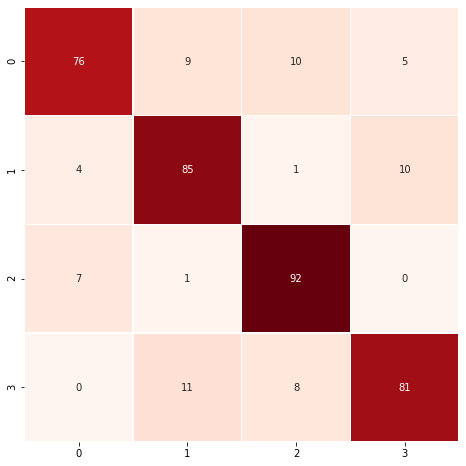

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       100
           1       0.80      0.85      0.83       100
           2       0.83      0.92      0.87       100
           3       0.84      0.81      0.83       100

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400



In [23]:
def train_optimized_xgboost(x_train, y_train, x_test, y_test):
    params = {
    'max_depth': [3, 5],
    'eta': [0.01, 0.1, 0.5, 0.75, 1.0, 5.0, 10.],
    'num_class': [4]}

    gridsearch = GridSearchCV(xgb.XGBClassifier(), params, refit=True, cv=5, scoring='balanced_accuracy').fit(x_train, y_train)
    best_model = gridsearch.best_estimator_
    y_test_predicted = best_model.predict(x_test)
    
    print("##### XGBoost Optimized #####")
    print("Best model {}".format(best_model))
    plot_confusion_matrix(y_test, y_test_predicted, colour="Reds")
    return apply_metric_func(y_true=y_test, y_pred=y_test_predicted, func_list=SUPERVISED_SCORES)

xgboost_res = train_optimized_xgboost(x_train=X_train, y_train=Y_train, x_test=X_validation_test, y_test=Y_validation_test)
SCORES_PER_METHOD[XGBOOST_key]["optimized"] = xgboost_res

## SVM optimized

##### SVM Optimized #####
Best model SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


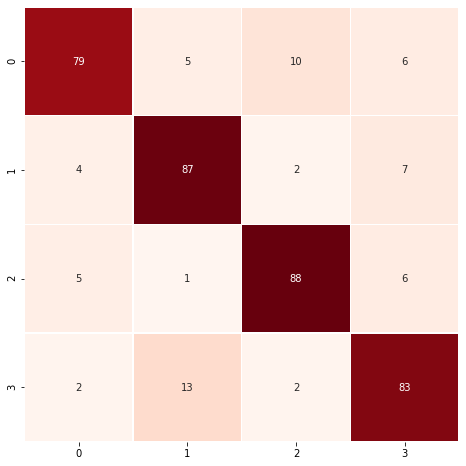

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       100
           1       0.82      0.87      0.84       100
           2       0.86      0.88      0.87       100
           3       0.81      0.83      0.82       100

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



In [25]:
def train_optimized_svm(x_train, y_train, x_test, y_test):
    params = {'C':[0.1, 0.5, 0.75, 1.0, 5.0],
              'kernel':['linear', 'poly', 'rbf'], 
              'degree':[2, 4],
              'gamma': ['scale', 'auto']}

    gridsearch = GridSearchCV(svm.SVC(), params, refit=True, cv=5, scoring='balanced_accuracy').fit(x_train, y_train)
    best_model = gridsearch.best_estimator_
    y_test_predicted = best_model.predict(x_test)
    
    print("##### SVM Optimized #####")
    print("Best model {}".format(best_model))
    plot_confusion_matrix(y_test, y_test_predicted, colour="Reds")
    return apply_metric_func(y_true=y_test, y_pred=y_test_predicted, func_list=SUPERVISED_SCORES)

svm_res = train_optimized_svm(x_train=X_train, y_train=Y_train, x_test=X_validation_test, y_test=Y_validation_test)
SCORES_PER_METHOD[SVM_KEY]["optimized"] = svm_res

## Naive Bayes optimized

##### Naive Bayes Optimized #####
Best model GaussianNB(priors=None, var_smoothing=0.001)


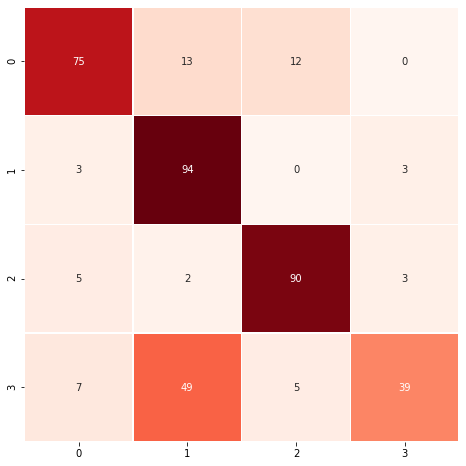

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       100
           1       0.59      0.94      0.73       100
           2       0.84      0.90      0.87       100
           3       0.87      0.39      0.54       100

    accuracy                           0.74       400
   macro avg       0.78      0.74      0.73       400
weighted avg       0.78      0.74      0.73       400



In [26]:
def train_optimized_naiveBayes(x_train, y_train, x_test, y_test):
    params = {'var_smoothing': [1e-09, 1e-05, 1e-03, 1.0]}

    gridsearch = GridSearchCV(GaussianNB(), params, refit=True, cv=5, scoring='balanced_accuracy').fit(x_train, y_train)
    best_model = gridsearch.best_estimator_
    y_test_predicted = best_model.predict(x_test)
    
    print("##### Naive Bayes Optimized #####")
    print("Best model {}".format(best_model))
    plot_confusion_matrix(y_test, y_test_predicted, colour="Reds")
    return apply_metric_func(y_true=y_test, y_pred=y_test_predicted, func_list=SUPERVISED_SCORES)

naiveBayes_res = train_optimized_naiveBayes(x_train=X_train, y_train=Y_train, x_test=X_validation_test, y_test=Y_validation_test)
SCORES_PER_METHOD[NAIVE_BAYES_KEY]["optimized"] = naiveBayes_res

## Comparison

### Inter-algorithm

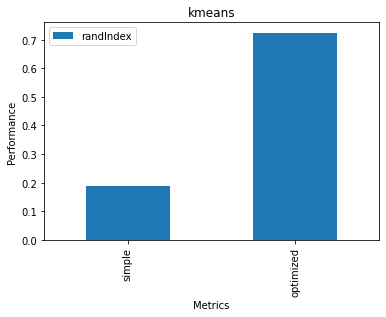

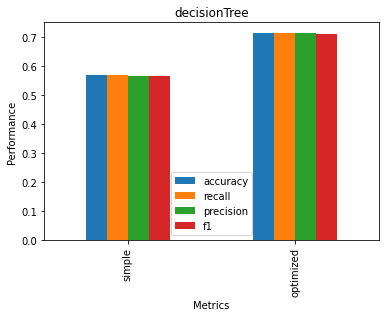

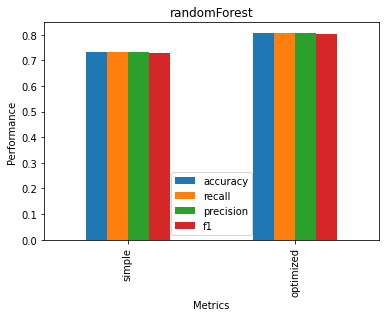

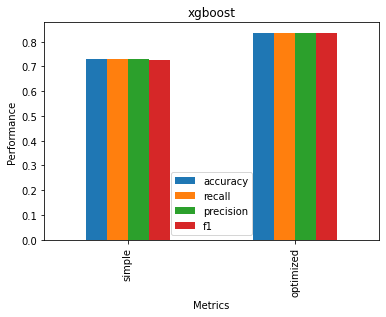

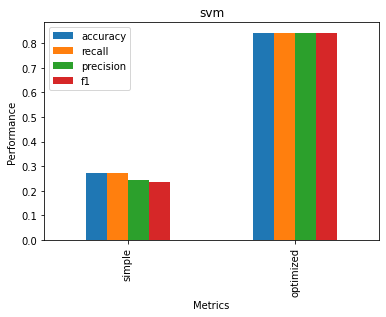

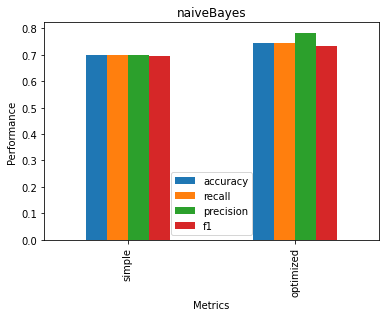

In [27]:
# intra-algorithm
for classifier_name in SCORES_PER_METHOD:
    keys_order = [key for key in SCORES_PER_METHOD[classifier_name]["simple"]]
    d = {key:[] for key in keys_order}
    for version in SCORES_PER_METHOD[classifier_name]:
        for key in SCORES_PER_METHOD[classifier_name][version]:
            d[key].append(SCORES_PER_METHOD[classifier_name][version][key])
    
    plotdata = pd.DataFrame(d, index=[version for version in SCORES_PER_METHOD[classifier_name]])
    plotdata.plot(kind="bar")
    plt.title(classifier_name)
    plt.xlabel("Metrics")
    plt.ylabel("Performance")



### Inter-algorithm

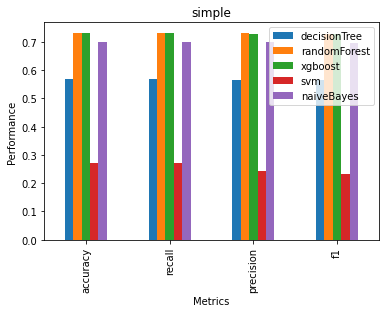

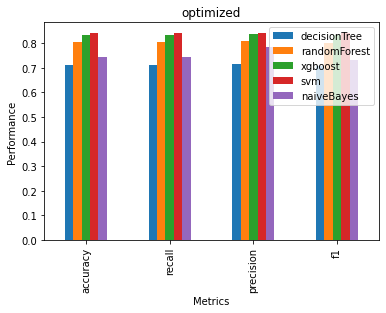

In [28]:
# intra-algorithm
for version in ["simple", "optimized"]:
    keys_order = [key for key in SCORES_PER_METHOD[XGBOOST_key][version]]
    classifier_names = [classifier_name for classifier_name in SCORES_PER_METHOD if classifier_name != KMEANS_KEY]
    d = {classifier_name:[] for classifier_name in classifier_names}
    for key in keys_order:
        for classifier_name in SCORES_PER_METHOD:
            if classifier_name != KMEANS_KEY:
                d[classifier_name].append(SCORES_PER_METHOD[classifier_name][version][key])
                  
    plotdata = pd.DataFrame(d, index=[func_name for func_name in keys_order])
    plotdata.plot(kind="bar")
    plt.title(version)
    plt.xlabel("Metrics")
    plt.ylabel("Performance")


## 5. Mențiuni

**Pentru rezolvarea task-urilor puteți folosi orice bibliotecă doriți.**

În scheletul temei, datele sunt încărcate folosind biblioteca [pandas](https://pandas.pydata.org/), însă puteți utiliza orice bibliotecă doriți.

**Algoritmii nu trebuie implementați de mână.**

"Rezolvarea" unei probleme de învățare automată se reduce la îmbunătățirea unei metrici.

Un prim pas important este reprezentat de crearea unui *baseline* sau a unei soluții banale, de start (eng. *vanilla solution*) și măsurarea acesteia.

Următorul pas îl reprezintă o serie de modificări aduse feature setului sau algoritmului de învățăre. Aceast pas reprezintă o iterație peste soluția inițială.

Tot procesul constă în aplicarea mai multor *iterații* până se ajunge la o valoare a metricii suficient de bună pentru problema de rezolvat. În cazul nostru, această valoare este reprezentată de ambiția fiecăruia dintre voi :)

**Recomandări**:
* biblioteca [sklearn](https://scikit-learn.org/) - oferă o colecție algoritmi de învățare automată, metrici, metode de selectare de caractaristici, etc.
* pentru XGBoost puteți folosit biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/)

## 6. Link-uri utile
* [Evaluarea algoritmilor de clusterizare](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)
* [Standardizare vs Normalizare](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc)

## Bibliografie
<a name="fma">[1] *Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, FMA: A Dataset For Music Analysis, 18th International Society for Music Information Retrieval Conference, 2017*</a>

